<a href="https://colab.research.google.com/github/janghwan0113/dog-classification/blob/main/Finalexam_%EC%95%88%EC%9E%A5%ED%99%98_2016145101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final - Kaggle Competition

In [ ]:
name = input("Name :")
ID = input("student ID :")

Name :안장환
student ID :2016145101


## Prepare

### Data download

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/21-2/basic_DL/Final

/content/drive/MyDrive/21-2/basic_DL/Final


In [ ]:
# 데이터 다운로드
!wget -c --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SbXvCdS1D6FppQOR3BtPtdOi1FzVuAGY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1SbXvCdS1D6FppQOR3BtPtdOi1FzVuAGY" -O dataset.zip

--2021-12-18 16:38:58--  https://docs.google.com/uc?export=download&confirm=3mK9&id=1SbXvCdS1D6FppQOR3BtPtdOi1FzVuAGY
Resolving docs.google.com (docs.google.com)... 74.125.195.139, 74.125.195.101, 74.125.195.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-4c-docs.googleusercontent.com/docs/securesc/dtn0pds7m2qh0ksthttt9r3lu5660tf7/rkb3unmu5dtan0m6j79vnskgee9sad3o/1639845525000/03451842904979350836/03699116806125397001Z/1SbXvCdS1D6FppQOR3BtPtdOi1FzVuAGY?e=download [following]
--2021-12-18 16:38:58--  https://doc-0o-4c-docs.googleusercontent.com/docs/securesc/dtn0pds7m2qh0ksthttt9r3lu5660tf7/rkb3unmu5dtan0m6j79vnskgee9sad3o/1639845525000/03451842904979350836/03699116806125397001Z/1SbXvCdS1D6FppQOR3BtPtdOi1FzVuAGY?e=download
Resolving doc-0o-4c-docs.googleusercontent.com (doc-0o-4c-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

In [ ]:
# "data"폴터를 만들어서 그 안에 압축 풀기
!unzip /content/drive/MyDrive/21-2/basic_DL/Final/dataset.zip -d /content/drive/MyDrive/21-2/basic_DL/Final

### Data Load with augmnetation

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import models

import os
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from torchvision.transforms.functional import affine
from torchvision.transforms.transforms import RandomHorizontalFlip

transform_train = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomRotation((-90,90)),
    transforms.RandomAffine((-72,72)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(), #이미지를 tensor자료형으로 변한
    transforms.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406]),
                std=torch.tensor([0.229, 0.224, 0.225]))]) # 정규화

transform_test = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(224),
    transforms.ToTensor(), #이미지를 tensor자료형으로 변한
    transforms.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406]),
                std=torch.tensor([0.229, 0.224, 0.225]))]) # 정규화

batch_size = 64

trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/21-2/basic_DL/Final/Train', transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/21-2/basic_DL/Final/Val', transform=transform_test)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


### Set labels (변경 금지)

In [ ]:
#alphable label
from string import ascii_lowercase

alphabet_list = list(ascii_lowercase)
alphabel_label =[]
for alphabet in alphabet_list:
    for sub in alphabet_list:
        alphabel_label.append(alphabet+sub)
alphabel_label = alphabel_label[:120]

## Model

In [ ]:
class DogNet(nn.Module): 
  def __init__(self):
      super(DogNet, self).__init__()

      
      self.avgpool = nn.AvgPool2d((7,7)) #512 7 7
      
      self.features = nn.Sequential(
          #3 224 224
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(64, 64, 3, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(2, 2),
          #64 112 112
          nn.Conv2d(64, 128, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(128, 128, 3, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(2, 2),
          #128 56 56
          nn.Conv2d(128, 256, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(256, 256, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(256, 256, 3, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(2, 2),
          #256 28 28
          nn.Conv2d(256, 512, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(512, 512, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(512, 512, 3, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(2, 2),
          #512 14 14
          nn.Conv2d(512, 512, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(512, 512, 3, padding=1),
          nn.ReLU(True),
          nn.Conv2d(512, 512, 3, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(2, 2)
      )


      self.classifier = nn.Sequential(
          nn.Linear(512 * 7 * 7, 4096),
          nn.ReLU(True),
          nn.Dropout(0.5),
          nn.Linear(4096, 120),
          )

  def forward(self, x):

      features = self.features(x)
      # x = self.avgpool(features)
      x = features.view(features.size(0), -1)
      x = self.classifier(x)
      return x

## Training

### Training-function

In [ ]:
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

class Trainer:
  def __init__(self, model, train_loader, opt, epoch_size=10, learning_rate=1e-2, use_cuda=True ):
    self.use_cuda = use_cuda #gpu 사용 여부
    if use_cuda :
      self.net = model.cuda() # gpu연산을 위한 model to gpu
    else :
      self.net = model
    self.train_loader = train_loader 
    self.opt = opt # optmizer 종류 설정을 위한 인자
    self.epoch_size = epoch_size # epoch
    self.learning_rate = learning_rate 
    self.validation_epoch = 1#int(epoch_size/10) # validation 빈도
    self.criterion = nn.CrossEntropyLoss() # loss

    self.history = {'train_acc':[],'val_acc':[],'train_loss':[],'val_loss':[]}

  def train(self, validation_loader=None):
  
    #Optimizer
    if self.opt == "SGD":
      optimizer = optim.SGD(self.net.parameters(), lr=self.learning_rate) 
    elif self.opt == "Adam":
      optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate) 
    elif self.opt == "Adagrad":
      optimizer = optim.Adagrad(self.net.parameters(), lr=self.learning_rate) 

    max_test_acc = 0

    for epoch in tqdm(range(self.epoch_size)):
      self.net.train() # weight&bias를 update할 수 있는 상태로 변환
    
      for i, (inputs, targets) in enumerate(self.train_loader): 

        if self.use_cuda: #gpu연산
          inputs = inputs.cuda() 
          targets = targets.cuda()

        # gradient를 0으로 초기화
        optimizer.zero_grad()
        
        outputs = self.net(inputs) #forward 
        
        loss = self.criterion(outputs, targets) #loss계산
        loss.backward() #backward -> gradient계산
        optimizer.step() #최적화 -> weight&bias update
      
      print(loss)

      self.history['train_loss'].append(loss.item())

      # if (epoch+1)%self.validation_epoch == 0:
      train_acc = self.validate(self.train_loader)
      self.history['train_acc'].append(train_acc)
      line = 'Train Acc | Epoch {:d}/{:d} | ACC {:f}'.format((epoch+1), self.epoch_size, train_acc)
      print(line)

      if validation_loader != None :
        val_acc = self.validate(validation_loader)
        self.history['val_acc'].append(val_acc)
        line_val = 'Val Acc | Epoch {:d}/{:d} | ACC {:f}'.format((epoch+1), self.epoch_size, val_acc)
        print(line_val)
      print("============================================")
      save(ckpt_dir = '/content/drive/MyDrive/21-2/basic_DL/Final/ckpt', net = self.net, optim = optimizer, epoch = epoch)

  @torch.no_grad()
  def validate(self, data_loader):
    self.net.eval()
    for i, (inputs, targets) in enumerate(data_loader): 
      if self.use_cuda: #gpu연산
        inputs = inputs.cuda() 
        targets = targets.cuda()

      pred = self.net(inputs) #forward
      
      
      val_loss = self.criterion(pred, targets)
           
      pred = torch.argmax(pred, dim = 1) #accuracy 측정
      pred_c = pred
      target_c = targets

      if i == 0:
        acc = (pred_c==target_c)
      else : 
        acc = torch.cat([acc, (pred_c==target_c)], axis=0)

    self.history['val_loss'].append(val_loss.item())    
    acc = acc.float().mean() * 100

    return acc.item()

  @torch.no_grad()
  def test_for_submit(self, data_loader): #kaggle 제출용 def
    ID = []
    prediction = []
    self.net.eval()
    for i, (id, image) in enumerate(data_loader): 
      if self.use_cuda: #gpu연산
        image = image.cuda() 
      
      pred = self.net(image) #forward
      pred = torch.argmax(pred, dim = 1).cpu().tolist()
      ID.extend(list(id))
      prediction.extend(pred)

    return ID, prediction


### example model check

In [ ]:
from torchsummary import summary

model = DogNet()
model.cuda()
## Model Summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
model

DogNet(
  (avgpool): AvgPool2d(kernel_size=(7, 7), stride=(7, 7), padding=0)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=

### Training and validation

### DogNet

In [ ]:
model = DogNet()
model.cuda()
trainer = Trainer(model, train_loader, "Adagrad",epoch_size=10,learning_rate=0.001) #trainer 객체 선언
trainer.train(val_loader) #training and validation

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(4.7865, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 1/10 | ACC 1.255264
Val Acc | Epoch 1/10 | ACC 1.166181
tensor(4.7517, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 2/10 | ACC 1.830256
Val Acc | Epoch 2/10 | ACC 1.822157
tensor(4.6895, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 3/10 | ACC 2.016521
Val Acc | Epoch 3/10 | ACC 1.627794
tensor(4.6599, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 4/10 | ACC 2.202786
Val Acc | Epoch 4/10 | ACC 2.040816
tensor(4.6323, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 5/10 | ACC 2.024620
Val Acc | Epoch 5/10 | ACC 1.822157
tensor(4.6850, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 6/10 | ACC 2.210884
Val Acc | Epoch 6/10 | ACC 2.040816
tensor(4.5636, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 7/10 | ACC 2.656301
Val Acc | Epoch 7/10 | ACC 2.332361
tensor(4.4592, device='cuda:0', grad_fn=<NllLossBackward0>)
Tr

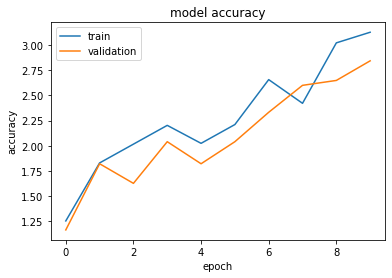

Maximum Train Accuracy : 3.1260125637054443
Maximum Validation Accuracy : 2.8425655364990234


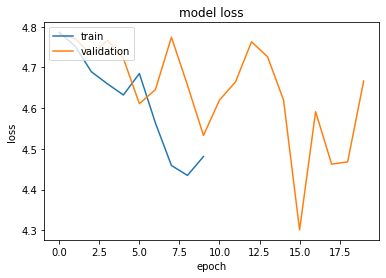

Minimum Train Loss : 4.434752464294434
Minimum Validation Loss : 4.300799369812012


In [ ]:
# plot train, val accuracy
plt.plot(trainer.history['train_acc'])
plt.plot(trainer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(trainer.history['train_acc'])}")
print(f"Maximum Validation Accuracy : {max(trainer.history['val_acc'])}")

# plot train, val loss
plt.plot(trainer.history['train_loss'])
plt.plot(trainer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(trainer.history['train_loss'])}")
print(f"Minimum Validation Loss : {min(trainer.history['val_loss'])}")

### VGG16 transfer training

In [ ]:
from torchvision import models

model = models.vgg16(pretrained=True) #True는 weight만 가져오기

In [ ]:
model

In [ ]:
linear1 = nn.Linear(4096, 2048)
linear2 = nn.Linear(2048, 1024)
linear3 = nn.Linear(1024, 512)
linear4 = nn.Linear(512, 256)
linear5 = nn.Linear(256, 120)


nn.init.kaiming_uniform_(linear1.weight)
nn.init.kaiming_uniform_(linear2.weight)
nn.init.kaiming_uniform_(linear3.weight)
nn.init.kaiming_uniform_(linear4.weight)
nn.init.kaiming_uniform_(linear5.weight)

model.fc =  nn.Sequential(
          linear1,
          nn.ReLU(True),
          nn.Dropout(0.5),
          linear2,
          nn.ReLU(True),
          nn.Dropout(0.5),
          linear3,
          nn.ReLU(True),
          nn.Dropout(0.5),
          linear4,
          nn.ReLU(True),
          nn.Dropout(0.5),
          linear5,
          nn.Dropout(0.5)
          )

In [ ]:
model

In [ ]:
model.cuda()

In [ ]:
trainer = Trainer(model, train_loader, "Adagrad",epoch_size=50,learning_rate=0.001) #trainer 객체 선언
trainer.train(val_loader) #training and validation

In [ ]:
# plot train, val accuracy
plt.plot(trainer.history['train_acc'])
plt.plot(trainer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(trainer.history['train_acc'])}")
print(f"Maximum Validation Accuracy : {max(trainer.history['val_acc'])}")

# plot train, val loss
plt.plot(trainer.history['train_loss'])
plt.plot(trainer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(trainer.history['train_loss'])}")
print(f"Minimum Validation Loss : {min(trainer.history['val_loss'])}")

### Inception v3

In [ ]:
from torchvision import models

model = models.inception_v3(pretrained=True) #True는 weight만 가져오기
model.cuda()

In [ ]:
model.aux_logits = False
model.fc = nn.Linear(2048, 120)


trainer = Trainer(model, train_loader, "Adagrad",epoch_size=100,learning_rate=0.001) #trainer 객체 선언
trainer.train(val_loader) #training and validation

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(2.4541, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 1/100 | ACC 48.939098
Val Acc | Epoch 1/100 | ACC 61.613213
tensor(1.8411, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 2/100 | ACC 59.361839
Val Acc | Epoch 2/100 | ACC 70.821182
tensor(1.4248, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 3/100 | ACC 63.435375
Val Acc | Epoch 3/100 | ACC 72.910599
tensor(1.4033, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 4/100 | ACC 66.472305
Val Acc | Epoch 4/100 | ACC 74.635567
tensor(1.5612, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 5/100 | ACC 68.367348
Val Acc | Epoch 5/100 | ACC 75.631676
tensor(1.1679, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 6/100 | ACC 69.120506
Val Acc | Epoch 6/100 | ACC 76.069000
tensor(1.6168, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 7/100 | ACC 70.335281
Val Acc | Epoch 7/100 | ACC 76.360542
tensor(0.8774, device='cuda:0', gr

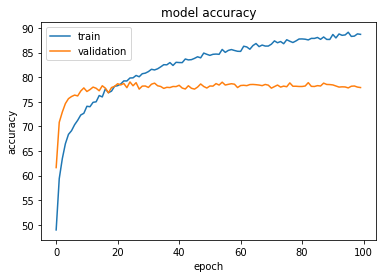

Maximum Train Accuracy : 89.13994598388672
Maximum Validation Accuracy : 79.03304290771484


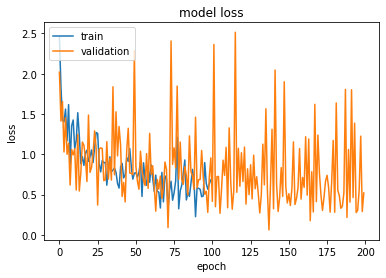

Minimum Train Loss : 0.2267521768808365
Minimum Validation Loss : 0.06254374235868454


In [ ]:
# plot train, val accuracy
plt.plot(trainer.history['train_acc'])
plt.plot(trainer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(trainer.history['train_acc'])}")
print(f"Maximum Validation Accuracy : {max(trainer.history['val_acc'])}")

# plot train, val loss
plt.plot(trainer.history['train_loss'])
plt.plot(trainer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(trainer.history['train_loss'])}")
print(f"Minimum Validation Loss : {min(trainer.history['val_loss'])}")

### Inception v3 He initialization

In [ ]:
model = models.inception_v3(pretrained=True) #True는 weight만 가져오기
model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model.aux_logits = False

linear1 = nn.Linear(2048, 512)
linear2 = nn.Linear(512, 120)

nn.init.kaiming_uniform_(linear1.weight)
nn.init.kaiming_uniform_(linear2.weight)

model.fc =  nn.Sequential(
          linear1,
          nn.ReLU(True),
          nn.Dropout(0.5),
          linear2,
          nn.Dropout(0.5),
          )

In [ ]:
trainer = Trainer(model, train_loader, "Adam",epoch_size=50,learning_rate=0.0001) #trainer 객체 선언
trainer.train(val_loader) #training and validation

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(4.5812, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 1/50 | ACC 16.933916
Val Acc | Epoch 1/50 | ACC 23.517979
tensor(4.4869, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 2/50 | ACC 32.094269
Val Acc | Epoch 2/50 | ACC 41.593781
tensor(3.9637, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 3/50 | ACC 40.864918
Val Acc | Epoch 3/50 | ACC 50.777454
tensor(3.7248, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 4/50 | ACC 47.222225
Val Acc | Epoch 4/50 | ACC 59.037899
tensor(3.9578, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 5/50 | ACC 52.494335
Val Acc | Epoch 5/50 | ACC 62.585033
tensor(3.9631, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 6/50 | ACC 54.154522
Val Acc | Epoch 6/50 | ACC 65.160355
tensor(3.5793, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 7/50 | ACC 56.235832
Val Acc | Epoch 7/50 | ACC 65.767738
tensor(3.6815, device='cuda:0', grad_fn=<NllLoss

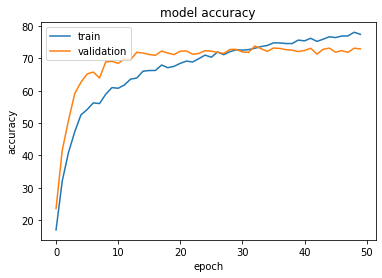

Maximum Train Accuracy : 78.08552551269531
Maximum Validation Accuracy : 73.80952453613281


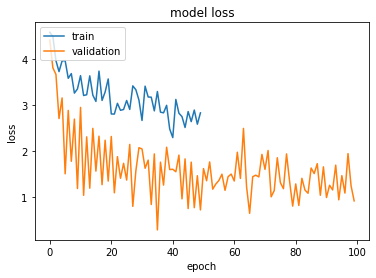

Minimum Train Loss : 2.289470672607422
Minimum Validation Loss : 0.2811557352542877


In [ ]:
# plot train, val accuracy
plt.plot(trainer.history['train_acc'])
plt.plot(trainer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(trainer.history['train_acc'])}")
print(f"Maximum Validation Accuracy : {max(trainer.history['val_acc'])}")

# plot train, val loss
plt.plot(trainer.history['train_loss'])
plt.plot(trainer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(trainer.history['train_loss'])}")
print(f"Minimum Validation Loss : {min(trainer.history['val_loss'])}")

### Inception v3 Adam

In [ ]:
from torchvision import models

model = models.inception_v3(pretrained=True) #True는 weight만 가져오기
model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model.aux_logits = False

linear1 = nn.Linear(2048, 120)

nn.init.kaiming_uniform_(linear1.weight)

model.fc =  nn.Sequential(
          linear1
          )

trainer = Trainer(model, train_loader, "Adam",epoch_size=30,learning_rate=0.001) #trainer 객체 선언
trainer.train(val_loader) #training and validation

  0%|          | 0/30 [00:00<?, ?it/s]

tensor(3.1605, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 1/30 | ACC 20.626822
Val Acc | Epoch 1/30 | ACC 23.979591
tensor(2.6767, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 2/30 | ACC 30.385489
Val Acc | Epoch 2/30 | ACC 30.685129
tensor(2.4093, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 3/30 | ACC 33.649174
Val Acc | Epoch 3/30 | ACC 34.863945
tensor(2.4253, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 4/30 | ACC 35.471333
Val Acc | Epoch 4/30 | ACC 39.577259
tensor(2.2456, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 5/30 | ACC 35.430840
Val Acc | Epoch 5/30 | ACC 38.726921
tensor(1.7016, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 6/30 | ACC 46.404278
Val Acc | Epoch 6/30 | ACC 48.177841
tensor(2.2717, device='cuda:0', grad_fn=<NllLossBackward0>)
Train Acc | Epoch 7/30 | ACC 44.889862
Val Acc | Epoch 7/30 | ACC 44.484936
tensor(2.2147, device='cuda:0', grad_fn=<NllLoss

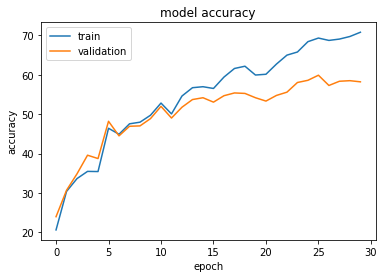

Maximum Train Accuracy : 70.7645034790039
Maximum Validation Accuracy : 59.86394119262695


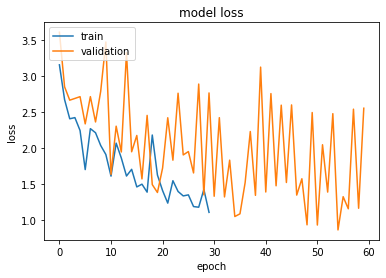

Minimum Train Loss : 1.1056238412857056
Minimum Validation Loss : 0.8611398935317993


In [ ]:
# plot train, val accuracy
plt.plot(trainer.history['train_acc'])
plt.plot(trainer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Maximum Train Accuracy : {max(trainer.history['train_acc'])}")
print(f"Maximum Validation Accuracy : {max(trainer.history['val_acc'])}")

# plot train, val loss
plt.plot(trainer.history['train_loss'])
plt.plot(trainer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(f"Minimum Train Loss : {min(trainer.history['train_loss'])}")
print(f"Minimum Validation Loss : {min(trainer.history['val_loss'])}")

## Test and Submit (변경 금지)

#### Test Loader

In [ ]:
import os

import cv2
import random
from PIL import Image
from torch.utils import data

class TestLoader(data.Dataset):
    def __init__(self, root, transform=None):
        super(TestLoader, self).__init__()

        self.root = root
        self.transform = transform
        self.test_root = os.path.join(self.root, "test")
        self.files = []
        self.id = []
        for i, (root, dirs, files) in enumerate(os.walk(self.test_root)):
          files.sort()
          for file in files:
            self.files.append(os.path.join(self.test_root,file))
            self.id.append(file.split('.')[0])


    def __getitem__(self, index):
        image_path = self.files[index]

        image = Image.open(image_path).convert('RGB')
        image_id = self.id[index]
        if self.transform:
            image = self.transform(image)

        return image_id, image

    def __len__(self):
        return len(self.files)


In [ ]:
testset = TestLoader(root='/content/drive/MyDrive/21-2/basic_DL/Final/Test', transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1) #Shuffle=False 절대 변경 금지!!!

### Test

In [ ]:
ID, prediction = trainer.test_for_submit(test_loader)

### Kaggle 제출용

In [ ]:
import csv
#csv파일 생성
with open('/content/drive/MyDrive/21-2/basic_DL/Final/dognet.csv', mode='w') as pred_file:
  pred_writer = csv.writer(pred_file, delimiter=',')
  pred_writer.writerow(['Id', 'Category'])
  for i in range(len(prediction)): 
    pred_writer.writerow([ID[i], alphabel_label[prediction[i]]])
  print("end ID : ",i)


## Test and Submit (변경 금지)

#### Test Loader

In [ ]:
import os

import cv2
import random
from PIL import Image
from torch.utils import data

class TestLoader(data.Dataset):
    def __init__(self, root, transform=None):
        super(TestLoader, self).__init__()

        self.root = root
        self.transform = transform
        self.test_root = os.path.join(self.root, "test")
        self.files = []
        self.id = []
        for i, (root, dirs, files) in enumerate(os.walk(self.test_root)):
          files.sort()
          for file in files:
            self.files.append(os.path.join(self.test_root,file))
            self.id.append(file.split('.')[0])


    def __getitem__(self, index):
        image_path = self.files[index]

        image = Image.open(image_path).convert('RGB')
        image_id = self.id[index]
        if self.transform:
            image = self.transform(image)

        return image_id, image

    def __len__(self):
        return len(self.files)


In [ ]:
testset = TestLoader(root='/content/drive/MyDrive/21-2/basic_DL/Final/Test', transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1) #Shuffle=False 절대 변경 금지!!!

### Test

In [ ]:
ID, prediction = trainer.test_for_submit(test_loader)

### Kaggle 제출용

In [ ]:
import csv
#csv파일 생성
with open('/content/drive/MyDrive/21-2/basic_DL/Final/inception_v3.csv', mode='w') as pred_file:
  pred_writer = csv.writer(pred_file, delimiter=',')
  pred_writer.writerow(['Id', 'Category'])
  for i in range(len(prediction)): 
    pred_writer.writerow([ID[i], alphabel_label[prediction[i]]])
  print("end ID : ",i)


end ID :  4115


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/21-2/basic_DL/Final')

## Test and Submit (변경 금지)

#### Test Loader

In [ ]:
import os

import cv2
import random
from PIL import Image
from torch.utils import data

class TestLoader(data.Dataset):
    def __init__(self, root, transform=None):
        super(TestLoader, self).__init__()

        self.root = root
        self.transform = transform
        self.test_root = os.path.join(self.root, "test")
        self.files = []
        self.id = []
        for i, (root, dirs, files) in enumerate(os.walk(self.test_root)):
          files.sort()
          for file in files:
            self.files.append(os.path.join(self.test_root,file))
            self.id.append(file.split('.')[0])


    def __getitem__(self, index):
        image_path = self.files[index]

        image = Image.open(image_path).convert('RGB')
        image_id = self.id[index]
        if self.transform:
            image = self.transform(image)

        return image_id, image

    def __len__(self):
        return len(self.files)


In [ ]:
testset = TestLoader(root='/content/drive/MyDrive/21-2/basic_DL/Final/Test', transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1) #Shuffle=False 절대 변경 금지!!!

### Test

In [ ]:
ID, prediction = trainer.test_for_submit(test_loader)

### Kaggle 제출용

In [ ]:
import csv
#csv파일 생성
with open('/content/drive/MyDrive/21-2/basic_DL/Final/inception_v3_He.csv', mode='w') as pred_file:
  pred_writer = csv.writer(pred_file, delimiter=',')
  pred_writer.writerow(['Id', 'Category'])
  for i in range(len(prediction)): 
    pred_writer.writerow([ID[i], alphabel_label[prediction[i]]])
  print("end ID : ",i)


end ID :  4115


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/21-2/basic_DL/Final')

## Test and Submit (변경 금지)

#### Test Loader

In [ ]:
import os

import cv2
import random
from PIL import Image
from torch.utils import data

class TestLoader(data.Dataset):
    def __init__(self, root, transform=None):
        super(TestLoader, self).__init__()

        self.root = root
        self.transform = transform
        self.test_root = os.path.join(self.root, "test")
        self.files = []
        self.id = []
        for i, (root, dirs, files) in enumerate(os.walk(self.test_root)):
          files.sort()
          for file in files:
            self.files.append(os.path.join(self.test_root,file))
            self.id.append(file.split('.')[0])


    def __getitem__(self, index):
        image_path = self.files[index]

        image = Image.open(image_path).convert('RGB')
        image_id = self.id[index]
        if self.transform:
            image = self.transform(image)

        return image_id, image

    def __len__(self):
        return len(self.files)


In [ ]:
testset = TestLoader(root='/content/drive/MyDrive/21-2/basic_DL/Final/Test', transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1) #Shuffle=False 절대 변경 금지!!!

### Test

In [ ]:
ID, prediction = trainer.test_for_submit(test_loader)

### Kaggle 제출용

In [ ]:
import csv
#csv파일 생성
with open('/content/drive/MyDrive/21-2/basic_DL/Final/inception_v3_Adam.csv', mode='w') as pred_file:
  pred_writer = csv.writer(pred_file, delimiter=',')
  pred_writer.writerow(['Id', 'Category'])
  for i in range(len(prediction)): 
    pred_writer.writerow([ID[i], alphabel_label[prediction[i]]])
  print("end ID : ",i)


end ID :  4115


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/21-2/basic_DL/Final')

IsADirectoryError: ignored